# Introduction to Large Language Models (LLMs) and Training Dataset

Large Language Models (LLMs) are advanced neural networks designed to understand and generate human language by learning from vast amounts of text data. These models capture complex patterns and context in language, enabling tasks such as text completion, translation, and summarization.

To train our LLM from scratch, we start by loading a training dataset. For this project, we intentionally use a relatively small dataset. This choice is driven by two main reasons:

- It allows the code to run efficiently on a standard laptop without requiring a powerful GPU.
- The training process completes quickly — in just a few minutes rather than weeks — making it ideal for educational purposes and experimentation.


# Loading the Training Dataset

This code snippet handles downloading and loading our training dataset of bedtime stories:

- It first checks if the file `gutenberg.txt` already exists locally.
- If the file is not found, it downloads the text data from the specified URL and saves it as `gutenberg.txt`.
- If the file already exists, it simply loads the data from the local file to avoid redundant downloads.

This ensures efficient use of resources by only downloading the dataset once and reusing it for subsequent runs.


In [1]:
import os
import urllib.request

file_path = "gutenberg.txt"
url = "https://qyxai.com/book_examples/bedtimestories.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

# Extracting a Subset of the Dataset

In this step, we slice the loaded text data to focus on a specific portion of the dataset for training:

- We extract the text from character index 30,707 up to 160,645.
- This helps to remove any unwanted headers, footers, or irrelevant parts from the original file.
- We then print the first 99 characters and the last 99 characters of this extracted segment to verify the content.

This ensures that the dataset used for training is clean and relevant.


In [2]:
text_data = text_data[30707:160645]

print(text_data[:99])

print(text_data[-99:])

old apple tree at the edge of Farmer Giles’ meadow. His home was snug, lined with dandelion fluff a
rked, their movements graceful and serene.

Mia watched, fascinated. It was like seeing a magical r


# Tokenization and Counting Tokens

Tokenization is the process of splitting text into smaller units called tokens, which can be words, subwords, or characters. Language models like GPT-2 work with tokens rather than raw text because tokens provide a standardized and efficient way to represent language data.

In the code snippet below:

- We use the `tiktoken` library to load the GPT-2 tokenizer, which follows the specific tokenization rules used by the GPT-2 model.
- The `encode` method converts the raw text into a sequence of tokens.
- We then calculate the total number of tokens in the dataset, which gives us insight into the dataset size from the model’s perspective.

Understanding the token count is essential since language models process and learn from text based on these tokens.


In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
total_tokens = len(tokenizer.encode(text_data))
print("Tokens:", total_tokens)

Tokens: 30091


# Preparing the Dataset and DataLoader for Training

To train our LLM to predict the next token in a sequence, we first split the dataset into training and validation sets. We then use PyTorch’s `Dataset` and `DataLoader` classes to create batches suitable for model training.

Key points about this process:

- We tokenize the entire text using the GPT-2 tokenizer.
- The dataset is divided into overlapping chunks (sliding windows) of a fixed length (`max_length`), with a defined stride to control overlap.
- Each chunk consists of an input sequence and a target sequence, where the target is the same as the input but shifted by one token to represent the "next token" prediction task.
- The custom `GPTDatasetV1` class handles this chunking and prepares tensors for inputs and targets.
- The `create_dataloader_v1` function wraps this dataset into a PyTorch `DataLoader`, which manages batching, shuffling, and parallel data loading.

This setup efficiently prepares the text data for training the language model to learn next-token prediction.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

# GPT Model Configuration Parameters (124M Version)

This dictionary defines the hyperparameters for the GPT model variant with approximately 124 million parameters:

- **`vocab_size` (50257):**  
  The size of the model’s vocabulary, representing the total number of unique tokens the model can recognize and generate.

- **`context_length` (256):**  
  The maximum length of the input sequence (in tokens) the model can process at once. Here, it's shortened from the original 1024 tokens to speed up training and reduce memory usage.

- **`emb_dim` (768):**  
  The dimension of the token embeddings and hidden representations within the model. This defines the size of the vector space in which tokens are represented.

- **`n_heads` (12):**  
  The number of attention heads in each multi-head self-attention layer. Multiple heads allow the model to focus on different parts of the input simultaneously.

- **`n_layers` (12):**  
  The number of transformer blocks stacked in the model. Each layer contains attention and feed-forward sub-layers.

- **`drop_rate` (0.1):**  
  Dropout rate applied during training to prevent overfitting by randomly zeroing out parts of the neural network.

- **`qkv_bias` (False):**  
  Indicates whether to include bias terms in the query, key, and value projections in the attention mechanism.


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


# Splitting Dataset and Creating DataLoaders for Training and Validation

- We split the dataset into training and validation sets using a 90%/10% ratio.
- `split_idx` calculates the index at which to split the text data accordingly.
- The training data is everything before the split index, and validation data is everything after.

Next, we create PyTorch DataLoaders for both sets using the previously defined `create_dataloader_v1` function:

- For the training loader:
  - Batch size is set to 2.
  - The sequence length (`max_length`) and stride are set according to the GPT model’s context length (256 tokens).
  - `drop_last=True` ensures incomplete batches are dropped for consistent batch sizes.
  - Shuffling is enabled to improve training robustness.
  
- For the validation loader:
  - Batch size is also 2.
  - The same sequence length and stride are used.
  - `drop_last=False` allows processing all validation data.
  - Shuffling is disabled for deterministic evaluation.

Setting a fixed random seed (`torch.manual_seed(123)`) ensures reproducibility of data shuffling and batch sampling.


In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# Sanity Check for Dataset Size vs. Context Length

Before training, we verify that both the training and validation datasets contain enough tokens to form at least one full sequence of the specified `context_length`.

- We calculate the number of tokens allocated to each dataset by multiplying the total tokens by their respective ratios (`train_ratio` for training, and `1 - train_ratio` for validation).
- If either dataset has fewer tokens than the model’s `context_length`, it means we cannot create even one complete input sequence for that set.
- When this happens, a warning message is displayed advising to either:
  - Decrease the `context_length`, or
  - Adjust the `train_ratio` to allocate more tokens to the smaller dataset.

This check helps ensure that our data loaders can properly generate batches for both training and validation without errors.


In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 27136
Validation tokens: 2816
All tokens: 29952


# Custom Components: LayerNorm, GELU Activation, and FeedForward Network

This section defines key building blocks used in the GPT model architecture:

---

### 1. `LayerNorm` (Layer Normalization)

- **Purpose:**  
  Normalizes the inputs across the embedding dimension to stabilize and speed up training.
  
- **Key Elements:**  
  - `eps` (epsilon): A small value added for numerical stability during division.  
  - `scale` (γ) and `shift` (β): Learnable parameters that allow the normalized output to be scaled and shifted, enabling the network to restore representational power if needed.
  
- **Forward Pass:**  
  - Computes the mean and variance of the input `x` along the last dimension (embedding dimension).  
  - Normalizes `x` by subtracting the mean and dividing by the standard deviation (square root of variance + epsilon).  
  - Applies the learned scale and shift to the normalized output.

---

### 2. `GELU` (Gaussian Error Linear Unit) Activation

- **Purpose:**  
  A smooth, non-linear activation function commonly used in transformers, which approximates the expected output of a stochastic regularization of inputs.
  
  
- **Effect:**  
  Allows small negative inputs to have a small positive output, enabling smoother gradients and better model performance compared to ReLU.

---

### 3. `FeedForward` Neural Network Module

- **Purpose:**  
  Implements the position-wise feed-forward network inside each transformer block.
  
- **Architecture:**  
  - **Expansion Layer:** Linear layer expanding the embedding dimension to four times larger (`4 * emb_dim`). This allows the network to learn more complex transformations.  
  - **Activation:** Applies the `GELU` activation for non-linearity.  
  - **Contraction Layer:** Projects the expanded features back to the original embedding dimension, preparing the output to be combined with residual connections.
  
- **Forward Pass:**  
  - Passes the input tensor `x` through the sequential layers defined above, transforming the features accordingly.

---

These components together help the transformer learn rich representations while maintaining stable and efficient training.


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

# Multi-Head Attention Mechanism Explained

Multi-Head Attention is a core component of the Transformer architecture that allows the model to focus on different parts of the input sequence simultaneously. This enhances the model’s ability to capture various relationships and dependencies in the data.

---

### What is Multi-Head Attention?

- **Attention** computes a weighted average of values, where weights (attention scores) are determined by the compatibility between queries and keys.
- Instead of a single attention mechanism, **multi-head attention** runs multiple attention operations ("heads") in parallel.  
- Each head attends to different parts of the input, allowing the model to capture diverse contextual information.
- The outputs of all heads are concatenated and linearly projected to form the final output.

---

### Breakdown of the Code Implementation

- **Initialization:**
  - `d_in`: Input embedding dimension.
  - `d_out`: Output embedding dimension (must be divisible by the number of heads).
  - `num_heads`: Number of parallel attention heads.
  - `head_dim`: Dimension per attention head (`d_out // num_heads`).
  - Three linear layers (`W_query`, `W_key`, `W_value`) transform inputs into queries, keys, and values.
  - `out_proj` linearly projects concatenated head outputs back to `d_out`.
  - A dropout layer is applied to attention weights for regularization.
  - A **causal mask** is created to ensure each token only attends to previous tokens (important for autoregressive models like GPT).

- **Forward Pass:**
  1. Input `x` shape: `(batch_size, num_tokens, d_in)`.
  2. Compute queries, keys, and values by applying the respective linear transformations.
  3. Reshape each to `(batch_size, num_tokens, num_heads, head_dim)` to separate attention heads.
  4. Transpose to `(batch_size, num_heads, num_tokens, head_dim)` for efficient batch matrix multiplication.
  5. Calculate scaled dot-product attention scores
  6. Apply the **causal mask** to prevent positions from attending to future tokens by masking out those attention scores (setting them to \(-\infty\)).
  7. Use `softmax` to convert masked scores into attention weights (probabilities).
  8. Apply dropout on the attention weights for regularization.
  9. Compute the weighted sum of values (`attn_weights @ values`), resulting in the context vector per head.
  10. Transpose and reshape context vectors to concatenate heads back into shape `(batch_size, num_tokens, d_out)`.
  11. Pass through the final linear projection (`out_proj`).

---

### Why This Matters

- Multi-head attention enables the model to:
  - Attend to multiple aspects of the sequence simultaneously.
  - Capture different types of relationships (e.g., syntax, semantics).
- The **causal mask** ensures the model maintains the autoregressive property needed for generative tasks, preventing "cheating" by looking ahead.

---

This implementation follows the original Transformer design, adapted for GPT-style autoregressive language modeling.


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

# Transformer Block Implementation

This class implements a single Transformer block, which is a fundamental building unit of the GPT model architecture. Each block consists of two main sub-layers: Multi-Head Attention and Feed-Forward Neural Network, each followed by normalization and residual (shortcut) connections.

---

### Components:

- **MultiHeadAttention (`self.att`):**  
  Performs self-attention over the input tokens, allowing the model to weigh different positions in the sequence based on relevance.

- **FeedForward (`self.ff`):**  
  A position-wise fully connected network that applies non-linear transformations to each token independently, enabling complex feature extraction.

- **LayerNorm (`self.norm1`, `self.norm2`):**  
  Normalizes the input to each sub-layer to stabilize and accelerate training.

- **Dropout (`self.drop_shortcut`):**  
  Randomly zeros parts of the input during training to reduce overfitting.

---

### Forward Pass Flow:

1. **Attention Block:**  
   - Apply layer normalization to the input.  
   - Pass normalized input through the multi-head attention mechanism.  
   - Apply dropout for regularization.  
   - Add the original input (shortcut) back to preserve information and improve gradient flow (residual connection).

2. **Feed-Forward Block:**  
   - Normalize the output of the attention block.  
   - Pass through the feed-forward network.  
   - Apply dropout again.  
   - Add the input of this sub-layer back via another residual connection.

---

### Output Shape:

- The input and output tensors maintain the shape `[batch_size, num_tokens, emb_dim]`.  
- For example, with a batch size of 2, sequence length of 4, and embedding dimension of 768, the tensor shape is `(2, 4, 768)`.

This design allows stacking multiple Transformer blocks to build deeper models capable of capturing complex language patterns.


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

# GPT Model Architecture

This class defines the full GPT model by stacking multiple Transformer blocks and adding token and positional embeddings.

---

### Key Components:

- **Token Embeddings (`self.tok_emb`):**  
  Converts input token indices into dense vectors of size `emb_dim`. These embeddings represent the semantic meaning of tokens.

- **Positional Embeddings (`self.pos_emb`):**  
  Since Transformers process tokens in parallel, positional embeddings provide information about each token's position in the sequence, allowing the model to understand token order.

- **Dropout on Embeddings (`self.drop_emb`):**  
  Applies dropout regularization to the combined embeddings to prevent overfitting.

- **Transformer Blocks (`self.trf_blocks`):**  
  A sequence of `n_layers` Transformer blocks (defined previously), each containing multi-head attention and feed-forward sublayers with normalization and residual connections.

- **Final LayerNorm (`self.final_norm`):**  
  Normalizes the output of the last Transformer block before the final projection.

- **Output Head (`self.out_head`):**  
  A linear layer that projects the final hidden states to the vocabulary size, producing logits for each token prediction.

---

### Forward Pass:

1. Input token indices `in_idx` of shape `[batch_size, seq_len]` are converted to embeddings.
2. Positional embeddings for each token position are generated and added to the token embeddings.
3. The combined embeddings go through dropout.
4. The sequence is passed through the stacked Transformer blocks.
5. The output is normalized and then projected to logits representing predicted token probabilities.

---

### Additional Notes:

- The model is initialized with a fixed random seed (`torch.manual_seed(123)`) for reproducibility.
- The model is set to evaluation mode (`model.eval()`) to disable dropout during inference.

This modular design enables the GPT model to learn contextual representations and generate coherent language sequences.


In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

NameError: name 'nn' is not defined

# Loss Calculation Functions

These functions compute the cross-entropy loss during training and evaluation for our GPT model.

---

### `calc_loss_batch`

- **Purpose:** Computes the loss for a single batch of input and target sequences.
- **Process:**
  - Moves the input and target tensors to the specified device (CPU or GPU).
  - Runs the model on the input batch to get the output logits.
  - Calculates cross-entropy loss between the predicted logits and the target tokens.
  - Flattens the logits and target tensors to align dimensions for loss computation.
- **Returns:** The loss value for that batch.

---

### `calc_loss_loader`

- **Purpose:** Computes the average loss over multiple batches from a data loader.
- **Process:**
  - Iterates over the data loader up to a specified number of batches (`num_batches`).
  - Calls `calc_loss_batch` for each batch and accumulates the loss.
  - Handles cases where the data loader might be empty or the requested number of batches exceeds available batches.
- **Returns:** The average loss across the evaluated batches.

---

These functions help monitor model performance during training and validation by providing batch-level and epoch-level loss metrics.


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.961539862290868
Validation loss: 10.966237386067709


In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

# Simple Training Loop for GPT Model

This function manages the training process of the GPT model over multiple epochs, including periodic evaluation and sample text generation.

---

### Function Inputs:

- `model`: The GPT model to be trained.
- `train_loader`: DataLoader for the training dataset.
- `val_loader`: DataLoader for the validation dataset.
- `optimizer`: Optimization algorithm used to update model weights.
- `device`: Computing device (CPU or GPU).
- `num_epochs`: Number of full passes through the training dataset.
- `eval_freq`: Frequency (in training steps) to run evaluation.
- `eval_iter`: Number of batches used during evaluation.
- `start_context`: Initial text context for sample generation.
- `tokenizer`: Tokenizer to encode/decode text for generation.

---

### Training Workflow:

1. **Initialize Tracking Variables:**  
   Lists to store training/validation losses and the number of tokens processed.

2. **Epoch Loop:**  
   Runs for the specified number of epochs.
   - Sets the model to training mode (`model.train()`).

3. **Batch Loop:**  
   For each batch in the training data:
   - Reset gradients (`optimizer.zero_grad()`).
   - Compute loss on the batch (`calc_loss_batch`).
   - Perform backpropagation (`loss.backward()`).
   - Update model weights (`optimizer.step()`).
   - Track the total number of tokens processed and the global training step count.

4. **Evaluation:**  
   Every `eval_freq` steps:
   - Evaluate the model on training and validation data (`evaluate_model`).
   - Record losses and tokens seen.
   - Print current training progress.

5. **Sample Generation:**  
   After each epoch, generate and print a sample text to qualitatively assess the model’s learning progress.

---

### Returns:

- `train_losses`: List of training losses recorded during evaluation.
- `val_losses`: List of validation losses recorded during evaluation.
- `track_tokens_seen`: List tracking the number of tokens processed at each evaluation point.

---

This function provides a straightforward yet effective training loop with monitoring and sample generation to observe the model's behavior over time.


In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

# Model Training Setup and Execution Time Tracking

---

### Overview:

- **Seed Initialization:**  
  Sets a fixed random seed (`torch.manual_seed(123)`) to ensure reproducibility of the training results.

- **Model and Optimizer:**  
  - Instantiates the GPT model with the defined configuration (`GPT_CONFIG_124M`).  
  - Moves the model to the specified device (CPU or GPU).  
  - Initializes the AdamW optimizer with a learning rate of 0.0004 and weight decay of 0.1 for regularization.

- **Training Parameters:**  
  - Runs training for 20 epochs.  
  - Evaluates training and validation loss every 5 steps, using 5 batches per evaluation.  
  - Starts sample text generation with the prompt `"Every effort moves you"`.  
  - Uses the specified tokenizer for encoding/decoding text.

- **Execution Time Tracking (Optional):**  
  - Records the start time before training begins.  
  - Records the end time after training completes.  
  - Calculates and prints the total training time in minutes.

---

This setup allows for controlled training with periodic evaluation and performance monitoring, while optionally measuring the total runtime for convenience.


In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.935, Val loss 9.897
Ep 1 (Step 000005): Train loss 8.416, Val loss 8.505
Ep 1 (Step 000010): Train loss 7.513, Val loss 7.624
Ep 1 (Step 000015): Train loss 6.943, Val loss 7.309
Ep 1 (Step 000020): Train loss 6.761, Val loss 7.207
Ep 1 (Step 000025): Train loss 6.812, Val loss 7.089
Ep 1 (Step 000030): Train loss 6.610, Val loss 7.007
Ep 1 (Step 000035): Train loss 6.177, Val loss 6.928
Ep 1 (Step 000040): Train loss 6.211, Val loss 6.886
Ep 1 (Step 000045): Train loss 6.273, Val loss 6.788
Ep 1 (Step 000050): Train loss 6.011, Val loss 6.746
Every effort moves you, and a little, and a little, and a little, and a little, and a little, and a little, and a little, and the moon, and a little, and a little, a little, and the moon, and a
Ep 2 (Step 000055): Train loss 5.803, Val loss 6.718
Ep 2 (Step 000060): Train loss 5.815, Val loss 6.664
Ep 2 (Step 000065): Train loss 5.709, Val loss 6.708
Ep 2 (Step 000070): Train loss 5.502, Val loss 6.533
Ep 2 (Step 

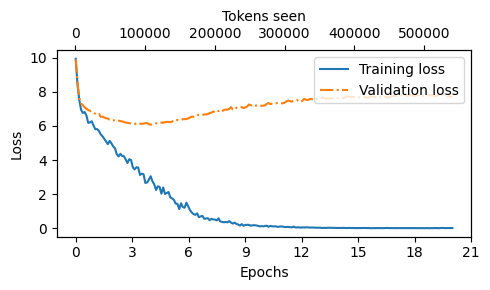

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The validation loss showed some initial improvement but then started to increase. This behavior can be addressed using techniques like temperature scaling or controlling randomness during training. However, these approaches are beyond the scope of the current experiment and will be explored in future work.